In [8]:
import os 
import tensorflow as tf 
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras import layers 
from tensorflow.keras import Model 
import matplotlib.pyplot as plt

In [9]:
import sys
import sklearn
import tensorflow as tf
import scipy

import cv2
import pandas as pd
import numpy as np

import plotly.graph_objs as go
from plotly.offline import iplot
from matplotlib import pyplot as plt

In [10]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [11]:
image_dict = {}

file_names = []
labels = []
from pathlib import Path
from tqdm import tqdm
for file in sorted((Path('A:/DeepFake project/content/Dataset').glob('*/*/*.*'))):
    label = str(file).split('\\')[-2]  # Extract the label from the file path
    labels.append(label)  # Add the label to the list
    file_names.append(str(file))  # Add the file path to the list

# Print the total number of file names and labels
print(len(file_names), len(labels))

# Create a pandas dataframe from the collected file names and labels
df = pd.DataFrame.from_dict({"image": file_names, "label": labels})
print(df.shape)

190335 190335
(190335, 2)


In [12]:
df.head()

,image,label
0,A:\DeepFake project\content\Dataset\Test\Fake\...,Fake
1,A:\DeepFake project\content\Dataset\Test\Fake\...,Fake
2,A:\DeepFake project\content\Dataset\Test\Fake\...,Fake
3,A:\DeepFake project\content\Dataset\Test\Fake\...,Fake
4,A:\DeepFake project\content\Dataset\Test\Fake\...,Fake


In [13]:
df.tail()

,image,label
190330,A:\DeepFake project\content\Dataset\Validation...,Real
190331,A:\DeepFake project\content\Dataset\Validation...,Real
190332,A:\DeepFake project\content\Dataset\Validation...,Real
190333,A:\DeepFake project\content\Dataset\Validation...,Real
190334,A:\DeepFake project\content\Dataset\Validation...,Real


In [14]:
df['label'].unique()

array(['Fake', 'Real'], dtype=object)

In [15]:
import warnings
warnings.filterwarnings("ignore")

In [16]:
import random
total_samples = len(df)

# Define the number of samples for training and testing
num_train_samples = 100000
num_test_samples = 20000
num_val_samples = 10000

# Generate random indices for training samples
train_indices = random.sample(range(total_samples), num_train_samples)

# Generate random indices for testing samples (exclude the ones already chosen for training)
test_indices = random.sample(set(range(total_samples)) - set(train_indices), num_test_samples)

val_indices = random.sample(set(range(total_samples))- set(test_indices),num_val_samples)

# Create subsets using the random indices
train_subset = [df.iloc[i] for i in train_indices]
test_subset = [df.iloc[i] for i in test_indices]
val_subset = [df.iloc[i] for i in val_indices]

# Display the lengths of the subsets
print("Number of training samples:", len(train_subset))
print("Number of test samples:", len(test_subset))
print("Number of validation samples:", len(val_subset))

Number of training samples: 100000
Number of test samples: 20000
Number of validation samples: 10000


In [17]:
train_df = pd.DataFrame(train_subset, columns=['image', 'label'])
test_df = pd.DataFrame(test_subset, columns=['image', 'label'])
val_df = pd.DataFrame(val_subset, columns=['image', 'label'])

In [18]:
train_df.head()

,image,label
26123,A:\DeepFake project\content\Dataset\Train\Fake...,Fake
56723,A:\DeepFake project\content\Dataset\Train\Fake...,Fake
156773,A:\DeepFake project\content\Dataset\Validation...,Fake
74593,A:\DeepFake project\content\Dataset\Train\Fake...,Fake
59675,A:\DeepFake project\content\Dataset\Train\Fake...,Fake


In [19]:
def plot_class_distribution(df):


    plt.figure(figsize=(6, 4))
    df.value_counts().plot(kind='bar', color=['teal', 'orange'])
    plt.title('Distribution of Classes')
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.xticks(rotation=0)
    plt.show()

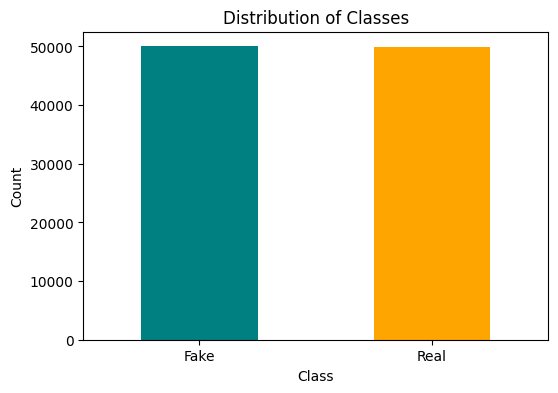

In [20]:
plot_class_distribution(train_df['label'])

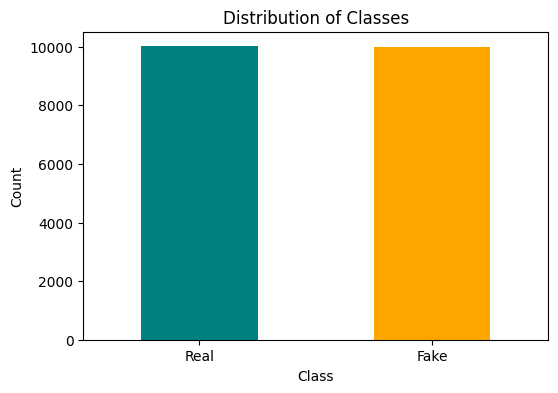

In [21]:
plot_class_distribution(test_df['label'])

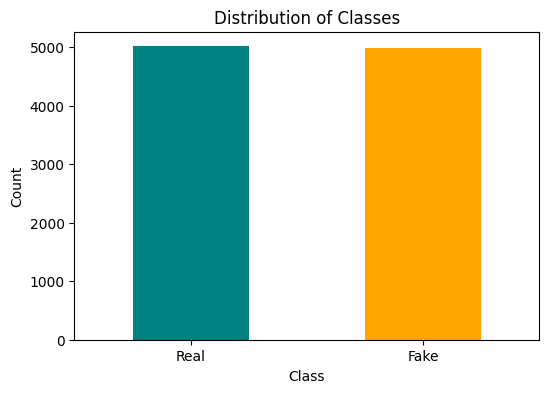

In [22]:
plot_class_distribution(val_df['label'])

In [23]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

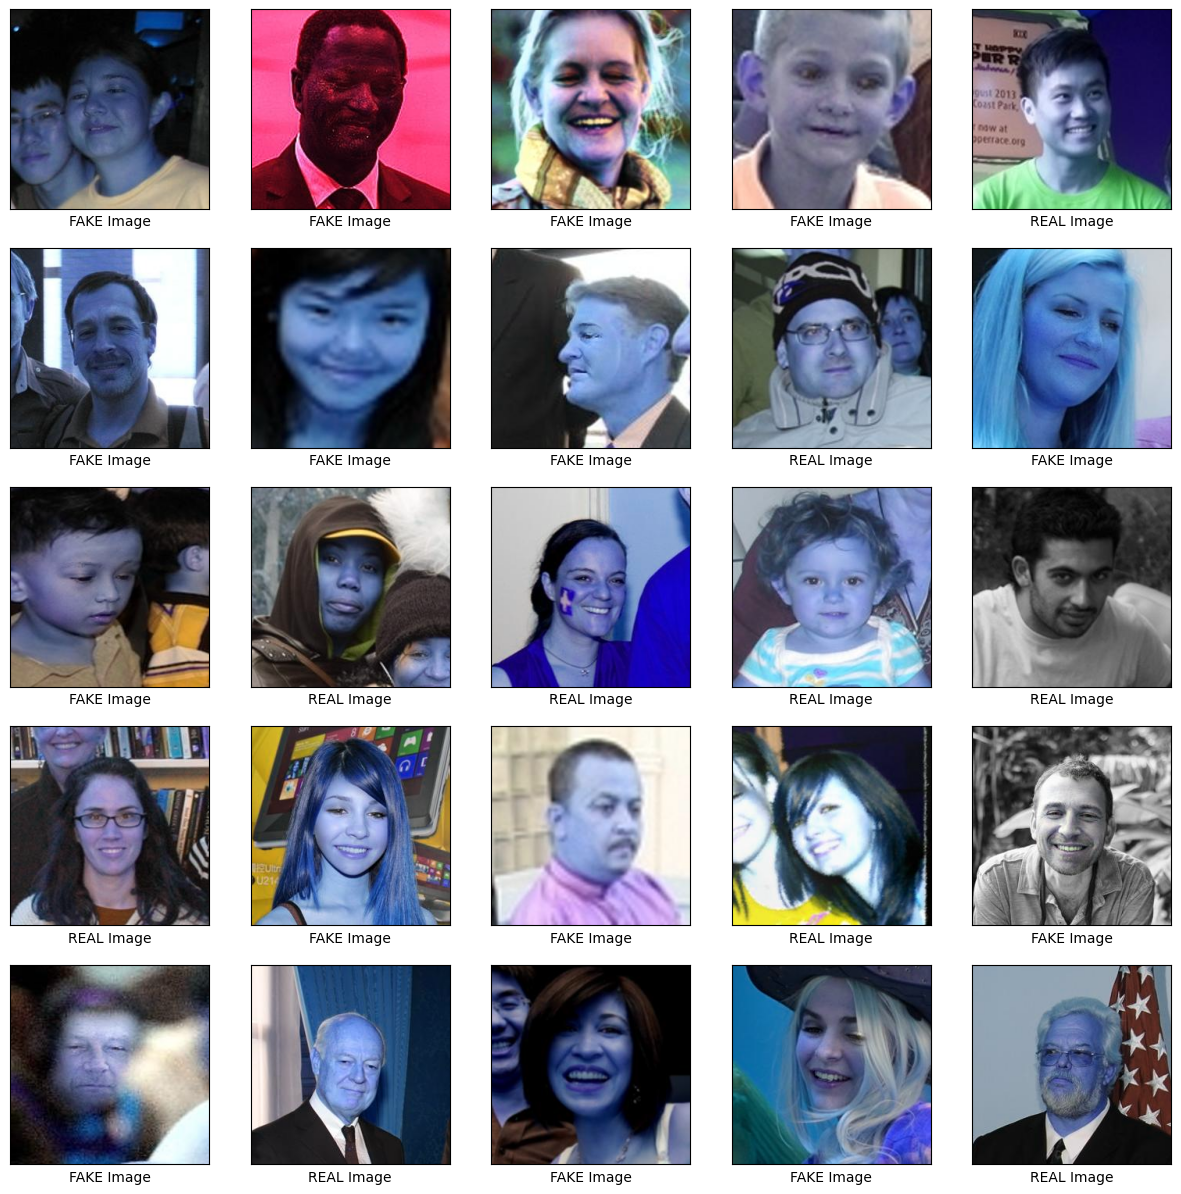

In [24]:
plt.figure(figsize=(15,15))
for cur,i in enumerate(train_df.index[25:50]):
    plt.subplot(5,5,cur+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)

    plt.imshow(cv2.imread(train_df.loc[i,'image']))

    if(train_df.loc[i,'label']=='Fake'):
        plt.xlabel('FAKE Image')
    else:
        plt.xlabel('REAL Image')

plt.show()

In [25]:
# train_datagen = ImageDataGenerator(rescale = 1./255.,rotation_range = 40, width_shift_range = 0.2, height_shift_range = 0.2, shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True)

train_datagen = ImageDataGenerator(rescale = 1./255.)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator( rescale = 1.0/255. )

In [26]:
train_generator = train_datagen.flow_from_dataframe(dataframe=train_df, directory=None,
                                                    x_col='image', y_col='label',
                                                    target_size=(224, 224),
                                                    batch_size=32,
                                                    class_mode='binary')
val_generator = val_datagen.flow_from_dataframe(dataframe=val_df, directory=None,
                                                x_col='image', y_col='label',
                                                target_size=(224, 224),
                                                batch_size=32,
                                                class_mode='binary')

test_generator = test_datagen.flow_from_dataframe(dataframe=test_df, directory=None,
                                                  x_col='image', y_col='label',
                                                  target_size=(224, 224),
                                                  batch_size=32,
                                                  class_mode='binary')

Found 100000 validated image filenames belonging to 2 classes.
Found 10000 validated image filenames belonging to 2 classes.
Found 20000 validated image filenames belonging to 2 classes.


In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16

base_model = VGG16(input_shape = (224, 224, 3), # Shape of our images
include_top = False, # Leave out the last fully connected layer
weights = 'imagenet')

In [ ]:
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Flatten
flatten_layer = Flatten()(base_model.output)
dense_layer1 = Dense(512, activation='relu')(flatten_layer)
dense_layer2 = Dense(256, activation='relu')(dense_layer1)
output_layer = Dense(1, activation='sigmoid')(dense_layer2)

model = tf.keras.models.Model(base_model.input, output_layer)


model.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0001), loss = 'binary_crossentropy',metrics = ['acc'])

In [ ]:
vgghist = model.fit(train_generator, validation_data = val_generator,batch_size=16, steps_per_epoch = 150, epochs = 18)

In [ ]:
model.save('A:/DeepFake project/saved_model/vgg_model.h5')

In [27]:
import efficientnet.keras as efn

In [28]:
base_efn = efn.EfficientNetB3(input_shape = (224, 224, 3), include_top = False, weights = 'imagenet')

In [29]:
for layer in base_efn.layers:
    layer.trainable = False

In [30]:
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout,Flatten


In [31]:
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report


In [32]:
x = GlobalAveragePooling2D()(base_efn.output)
# x = Flatten()(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.4)(x)

predictions = Dense(1, activation="sigmoid")(x)
model_final = Model(inputs = base_efn.input, outputs = predictions)

In [33]:
model_final.compile(optimizer=Adam(),loss='binary_crossentropy',metrics=['accuracy'])

In [ ]:
model_final.summary()

In [34]:
eff_history = model_final.fit_generator(train_generator, validation_data = val_generator, steps_per_epoch = 400, epochs = 15)

Epoch 1/15
400/400 [==============================] - 200s 465ms/step - loss: 0.5127 - accuracy: 0.7469 - val_loss: 0.4639 - val_accuracy: 0.7736
Epoch 2/15
400/400 [==============================] - 183s 458ms/step - loss: 0.4767 - accuracy: 0.7702 - val_loss: 0.4428 - val_accuracy: 0.7879
Epoch 3/15
400/400 [==============================] - 180s 451ms/step - loss: 0.4683 - accuracy: 0.7768 - val_loss: 0.4533 - val_accuracy: 0.7795
Epoch 4/15
400/400 [==============================] - 181s 452ms/step - loss: 0.4540 - accuracy: 0.7818 - val_loss: 0.4245 - val_accuracy: 0.7992
Epoch 5/15
400/400 [==============================] - 181s 452ms/step - loss: 0.4555 - accuracy: 0.7800 - val_loss: 0.4208 - val_accuracy: 0.8023
Epoch 6/15
400/400 [==============================] - 181s 452ms/step - loss: 0.4520 - accuracy: 0.7849 - val_loss: 0.4329 - val_accuracy: 0.7933
Epoch 7/15
400/400 [==============================] - 175s 439ms/step - loss: 0.4475 - accuracy: 0.7836 - val_loss: 0.4139 -

In [35]:
test_loss, test_accuracy = model_final.evaluate(test_generator, steps=test_generator.samples // 32)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')

625/625 [==============================] - 164s 262ms/step - loss: 0.4160 - accuracy: 0.8041
Test Loss: 0.41602811217308044, Test Accuracy: 0.804099977016449


In [37]:
model_final.save('A:/DeepFake project/saved_model/deepfake_model.h5')

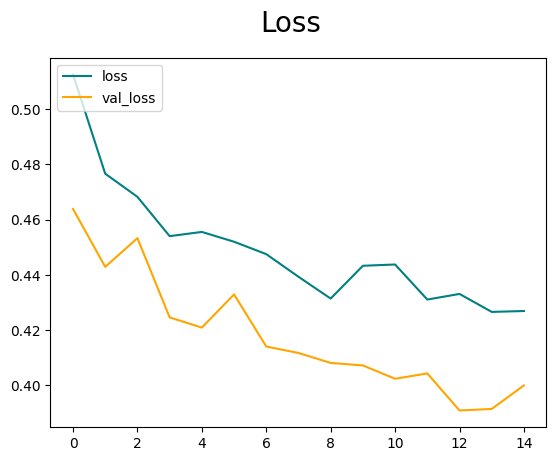

In [38]:
fig = plt.figure()
plt.plot(eff_history.history['loss'], color='teal',label='loss')
plt.plot(eff_history.history['val_loss'], color='orange',label='val_loss')
fig.suptitle('Loss',fontsize=20)
plt.legend(loc="upper left")
plt.show()

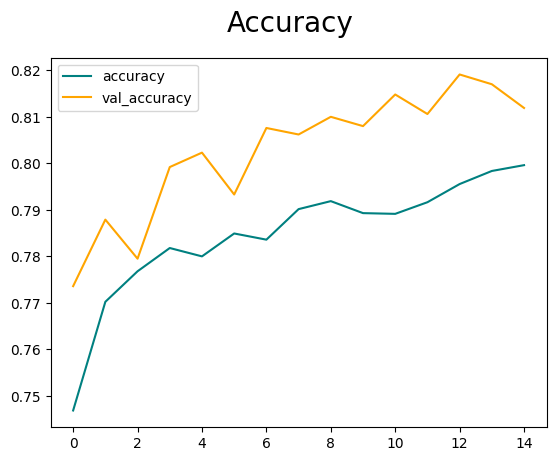

In [41]:
fig = plt.figure()
plt.plot(eff_history.history['accuracy'], color='teal',label='accuracy')
plt.plot(eff_history.history['val_accuracy'], color='orange',label='val_accuracy')
fig.suptitle('Accuracy',fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [ ]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [12]:
from PIL import Image
import numpy as np
def predict_image_class(image_path,model):
    # Load the pre-trained MobileNet model from TensorFlow Hub

    # Load and preprocess the image
    image = Image.open(image_path)
    image = image.resize((224, 224))
    image = np.array(image) / 255.0 
    image = np.expand_dims(image, axis=0)

    prediction = model.predict(image)
    print(prediction)
    predicted_class = 'Real Image' if prediction[0][0] > 0.5 else 'Fake Image'
    return predicted_class

In [17]:
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
model = tf.keras.models.load_model("A:/DeepFake project/saved_model/efn_model")

1/1 [==============================] - 0s 288ms/step
[[0.97090065]]


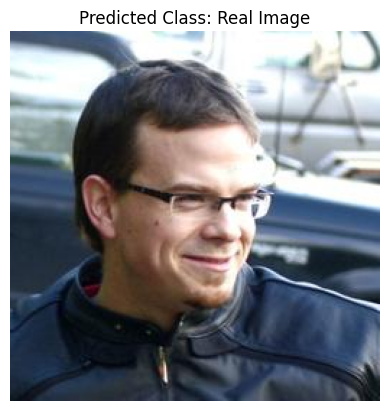

In [18]:
image_path = "A:/DeepFake project/content/Dataset/Validation/Real/real_72.jpg"
im = cv2.imread(image_path)
image_rgb = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
predicted_class = predict_image_class(image_path,model)
plt.figure()
plt.imshow(image_rgb)
plt.title(f"Predicted Class: {predicted_class}")
plt.axis('off')  # Hide the axes
plt.show()

In [ ]:
"A:\DeepFake project\saved_model\vgg_model\saved_model.pb"